# Поиск HTTP запросов

# Импорт библиотек

In [1]:
%config IPCompleter.greedy=True  # автозаполнение для удобства написания кода

Общие потребности

In [2]:
import pandas as pd
import numpy as np

Для обработки текста

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
from sklearn.decomposition import PCA

Для кластеризации (разделения запросов на группы для исследования признаков и доразметки)

In [5]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

Для рисования графиков

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

Для классификации запросов

In [7]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

Для оценки качества работы алгоритма

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Для сохранения модели

In [9]:
import joblib

# Исследование данных

## Взгляд сверху

### Общий вид

Посмоторим, как выглядят первые 10 строк. По входной информации, это описание HTTP-запросов, среди которых есть вредоносные и опасные. Столбца "разметка" или подобного, описывающего классы, на первый взгляд, нет.

# Загрузка данных

In [10]:
df = pd.read_csv('data/part_10.csv', encoding='utf8')

In [11]:
df.head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp
5,79.183.87.247,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,682,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,nFzwHGQB5cBXmMW1y_TD
6,88.198.201.245,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1031,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.rid,3585221644,9KP-ImQB5cBXmMW1yeXY
7,77.72.142.170,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,763,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,214296569,97JpJGQB5cBXmMW1WqBh
8,94.50.192.153,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,3786,404,REQUEST_METHOD\';\'REQUEST_CONTE,NaN,POST\';\'multipart/form-data; boundary=----Web...,irs7_mMBjksgoq1eoQ7a
9,83.246.141.54,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,840,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,51660445,g4RdIGQB5cBXmMW10nGg


Общая характеристика данных. Видно, что некоторые столбцы почти полностью состоят из уникальных значений. Возможно, позже можно будет выделить из них информативную часть.

In [12]:
df.describe()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
count,57838,57517,57794,57770,57730,53167,57683,57666
unique,24940,6992,5758,60,21,3209,57611,54410
top,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,259,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height...",cr1nJWQB5cBXmMW1hh_4
freq,11286,2117,261,25771,20812,11165,28,7


### Код ответа: странные значения и обнаружение названий классов атак

Код ответа описан в стандартах, и может пригодиться в дальнейшем. Посмотрим распределение.

Видно, что, кроме частовстречающихся допустимых трёхзначных кодов есть ещё коды, похожие на хеш - длина у всех одинаковая, содержание как будто случайное.

Также заметно, что много кодов, начинающихся не с "2" - предполагаю, это не нормальная ситуация.

In [13]:
df.RESPONSE_CODE.value_counts()

200                                 25771
404                                 20367
302                                  6630
403                                  1156
304                                   940
504                                   700
301                                   584
502                                   558
500                                   318
400                                   212
204                                   116
206                                    90
307                                    74
405                                    63
503                                    62
401                                    46
303                                    37
207                                     4
8db0d594d4b89f35dbedc593c724c29b        1
dcbfc5eef493e919119fd48eb4f957ad        1
fc59a2c72afacddb8f8492c3c065b0e0        1
d64bdad286ae021642535d4f119a0546        1
01bfebabb27b66e033b76a34951b41cb        1
b09268bd2d762c0a2b222c2575c658ba  

Посмотрим, что за странные записи с хешами вместо кодов ответов.

Их оказалось не так уж и много. И интересная особенность - в поле "CLIENT_USERAGENT" таких записей указан класс уязвимости - "SQL Injection" или "Cross-Site Scripting". Другая особенность (возможно, чем-то позже будет объяснена) - в поле "REQUEST_SIZE" у всех них код имеет формат AVd.*Ppo9zF

И ещё одна особенность - визуально похоже, что это "сдвинутая" предыдущая строка. Как будто что-то было записно в предыдущую колонку в формате генерирующего записи средства, а при записи в CSV оказалось дублирование разделяющих символов.

In [14]:
df[df.RESPONSE_CODE.str.contains('^.{4,}$', regex=True, na=False)].shape

(40, 8)

In [15]:
df[df.RESPONSE_CODE.str.contains('^.{4,}$', regex=True, na=False)].head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
4185,\n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...,SQL Injection,AVdfPawjq1Ppo9zF4R4n,5cae7339ed82e2077c9a5da7c92c698a,NaN,NaN,NaN,NaN
10085,)vÕêx¥Å>W!¡´´üS©ó²l3¸©qKÙNâ± )ø§⟊»)qRâ...,SQL Injection,AVdXVhQZq1Ppo9zFzqqW,deea16e940c6e2818a7efe1d1ad201f0,NaN,NaN,NaN,NaN
10962,«e;½@õÍs ßëþ5â±]ÜÀ,SQL Injection,AVdpg3z4q1Ppo9zF9i1G,74d646cee1d7d983cf7a6cef6a644040,NaN,NaN,NaN,NaN
12146,I·`)ó>ïï #��é=AþyÒzþü ëVEݴG>E¼É!õý¿=Àûg...,Cross-Site Scripting,AVdXQUGaq1Ppo9zFznch,1f71588787ee4ee0ef301328471e64e9,NaN,NaN,NaN,NaN
12800,r÷ÑÎÛN7 ÏÓÇéZ(ó)Eý¥c6uóƍóm°#p,SQL Injection,AVdsbKxEq1Ppo9zF_EsP,b9b029604bb4efdc880d2be07739b7e7,NaN,NaN,NaN,NaN
13519,"> -gOxT""O<Ghèe]Ø È8¦n4íÇ־ñ }y ðù!T'|k...",SQL Injection,AVdmhteYq1Ppo9zF8HOJ,6bc76f3105219540d0a22d044d4e081a,NaN,NaN,NaN,NaN
13861,ihõ¥m@uSµÀZZJZ6$JZJZ.ÒÒRU,SQL Injection,AVdXLpqFq1Ppo9zFzkUK,95a83719d9c83d19251a06ba7fcaf9ac,NaN,NaN,NaN,NaN
14642,"0V9ó´zAXGTþ8þtÎ6íDÇëþT³µP,'#ûÌHϯ5i...",SQL Injection,AVdiJ5Rjq1Ppo9zF5kDu,62233793489a0ab0e8f20644a915daa0,NaN,NaN,NaN,NaN


Предположение - возможно, такие записи следуют за другими "нормальными". Проверим - посмотрим несколько записей подряд в окрестности "странных". Начнём с 50 записи. Видно, что 49 запись имеет нормальный формат - во всяком случае, заканчивается ID события, как и все другие

In [16]:
df.loc[47:52]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
47,5.142.70.112,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,949,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516689224689,kFdZHGQB5cBXmMW1ZejV
48,93.115.95.207,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,657,200,REQUEST_GET_ARGS,id,3 AND ORD(MID((SELECT IFNULL(CAST(email AS CHA...,AVdsppvPq1Ppo9zF_L2X
49,37.122.53.229,Mozilla/5.0 (Linux; Android 4.4.2; ZTE Blade L...,1124,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 4.4.2; ZTE Blade L...,Mnl0H2QB5cBXmMW15C-u
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
51,176.83.168.49,Mozilla/5.0 (Linux; Android 7.0; LG-M200 Build...,1042,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.TS,"20180125T000651,33Z",jsCd_mMBjksgoq1esPxd
52,178.89.162.79,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,957,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,95371276,BWggHmQB5cBXmMW1GmPl


Посмотрим ещё на 1308 запись: предыдущие записи похожи на обычные. Следующая запись содержит нечто, похожее на обход директорий (Path Traversal), но это совсем не SQL Injection

In [17]:
df.loc[1306:1310]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
1306,82.202.246.52,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1200,500,REQUEST_GET_ARGS,REQUEST_GET_ARGS.statusRid,3562445378,YFmYHGQB5cBXmMW1ifjM
1307,178.207.239.152,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1494,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,604793957,cKC9ImQB5cBXmMW1gctS
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
1309,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,567,500,REQUEST_URI,NaN,/rich//....//....//....//....//....//....//......,ku59A2QBjksgoq1eveUs
1310,188.165.234.52,Mozilla/5.0 (X11; U; Linux i586; en-US) AppleW...,318,302,REQUEST_GET_ARGS,ur,http://www.lgz.ru/article/11269/,AVdqm0Wfq1Ppo9zF-GrI


Посмотрим - может быть, такие странные записи создаются для одного источника, следуют одна за другой, но разделены записями от других источников? Также начнём с 50 записи. Посмотрим, что в CLIENT_IP

In [18]:
df.loc[50].CLIENT_IP

'> -gOxT"O<Ghè\x19e]Ø\x1d\x81È8\xa0G\x88\x87`\x08\x07\x83Qf¾\x86ñ\x1e\x93}\x7fy\x1c\x96ðù\x88!T\'|kó\x07s\x8c;©èE\x1e \x8dáÐìcqµѭцAÃ,\x0e\x08ÈÈëéO`>y¢¾\x96Ô,®/ô=>;tó\x1c-³\x91¹Wå\x10\x11\x9c¹QԊñ©´-NÝK½«àrJ\x94|\x0f\\#1¦3\x8eÎjA^õ¡ÿ'

Видны какие-то "кракозябры", шестнадцатеричные значения. Вернём в байты. Понятнее не стало.

In [19]:
df.loc[50].CLIENT_IP.encode('utf-8')

b'> -gOxT"O<Gh\xc3\xa8\x19e]\xc3\x98\x1d\xc2\x81\xc3\x888\xc2\xa0G\xc2\x88\xc2\x87`\x08\x07\xc2\x83Qf\xc2\xbe\xc2\x86\xc3\xb1\x1e\xc2\x93}\x7fy\x1c\xc2\x96\xc3\xb0\xc3\xb9\xc2\x88!T\'|k\xc3\xb3\x07s\xc2\x8c;\xc2\xa9\xc3\xa8E\x1e \xc2\x8d\xc3\xa1\xc3\x90\xc3\xaccq\xc2\xb5\xd1\xad\xd1\x86A\xc3\x83,\x0e\x08\xc3\x88\xc3\x88\xc3\xab\xc3\xa9O`>y\xc2\xa2\xc2\xbe\xc2\x96\xc3\x94,\xc2\xae/\xc3\xb4=>;t\xc3\xb3\x1c-\xc2\xb3\xc2\x91\xc2\xb9W\xc3\xa5\x10\x11\xc2\x9c\xc2\xb9Q\xd4\x8a\xc3\xb1\xc2\xa9\xc2\xb4-N\xc3\x9dK\xc2\xbd\xc2\xab\xc3\xa0rJ\xc2\x94|\x0f\\#1\xc2\xa63\xc2\x8e\xc3\x8ejA^\xc3\xb5\xc2\xa1\xc3\xbf'

"Нормальные" коды ответов тоже распределены необычно - много формата 4хх. Возможно, получится использовать их в качестве одного из признаков.

<AxesSubplot:>

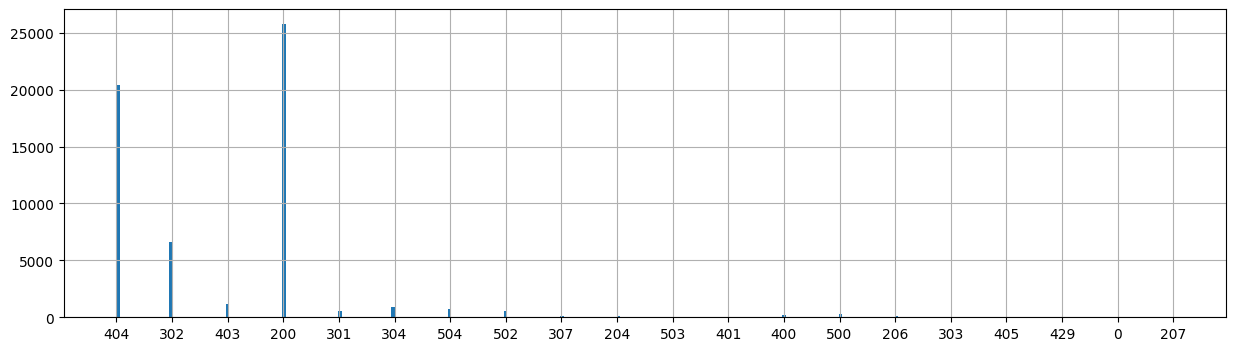

In [20]:
df[df.RESPONSE_CODE.str.len() < 4].RESPONSE_CODE.hist(bins=300, figsize=(15, 4))

### Ненормальные IP-адреса

Посмотрим записи, в которых адреса клиентов не похожи по формату на обычные IPv4 или IPv6.

In [21]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].shape

(115, 8)

Из интересных вхождений появилось ещё "Remote Code Execution"

In [22]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
162,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,4df2f46285c84ba39fa84fc4878214ae,NaN,NaN,NaN,NaN,NaN
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
1894,Remote Code Execution,AVddr1QQq1Ppo9zF3Vuj,0b168993dda4ce786f3455d01e162a58,NaN,NaN,NaN,NaN,NaN
1922,Ä}jSL 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,րÿ,AVdo4TiJq1Ppo9zF9OU0,NaN,NaN,NaN,NaN,NaN,NaN
3231,M{5¯ۯXµ #©نFî>R·8çp QÌû¿¼G̓X¿,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3344,Remote Code Execution,AVddRtA4q1Ppo9zF3E0u,f44ca434dfc32f17dff464956033f461,NaN,NaN,NaN,NaN,NaN
3671,¸#ØÓ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4144,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].CLIENT_USERAGENT.value_counts().head(5)

SQL Injection           35
Cross-Site Scripting     5
AVddXYBdq1Ppo9zF3IC6     1
AVdYVoMnq1Ppo9zF0VU9     1
AVdmgW85q1Ppo9zF8Gk4     1
Name: CLIENT_USERAGENT, dtype: int64

In [24]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].CLIENT_IP.value_counts().head(5)

Remote Code Execution    19
f~|°ØÀ¶
g8%ú·P:V­     5
SQL Injection             4
¢×˾û8äyªû¬Aü           2
¿b_                      2
Name: CLIENT_IP, dtype: int64

Видно, что в данных "неправильного" формата упоминаются SQL Injection, Cross-Site Scripting, Remote Code Execution. Предположительно, это логи какой-то IDS, но пока непонятно, к каким записям они относятся, и как с этими записями их связать.

### Поле USERAGENT

Представиться можно любым узлом, поэтому маловероятно, что это поле будет признаком для поиска "настоящих" уязвимостей. Тем не менее, интересные штуки - например, для разметки и обучения - отсюда можно достать. Так, например, useragent OpenVAS (заметил при поиске XSS ниже) может быть условием для разметки записи как вредоносной. Понятно, что нормальный злоумышленник представляться OpenVAS'ом не будет (хотя почему бы и нет), но так мы хотя бы наберём больше данных.

In [25]:
df.head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp


In [26]:
df.CLIENT_USERAGENT.value_counts().head(10)

Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko                                                   2117
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36     1806
Mozilla/5.0 (compatible; AhrefsBot/5.2; +http://ahrefs.com/robot/)                                                     1805
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36    1677
Google Update/1.3.33.7;winhttp;cup-ecdsa                                                                               1537
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11           1304
MICROSOFT_DEVICE_METADATA_RETRIEVAL_CLIENT                                                                             1225
Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)                                                       1006
Mozilla/

### Запросы от OpenVAS

Посмотрим запросы от OpenVAS (вероятно, вредоносные) и посмотрим, что оттуда можно вытянуть. Сходу видны Path Traversal (../ или ..%2f)

In [27]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].MATCHED_VARIABLE_VALUE.shape

(464,)

In [28]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].MATCHED_VARIABLE_VALUE.head(5)

136    /otcdealsin/shopper.cgi?newpage=../../../../.....
144    /openmairie_Tel/scr/soustab.php?dsn[phptype]=....
347    /otcdeals/Scripts/ref/noty/charts.php?language...
388    /metalexp/frontend/js.php?module=../../../../....
480    /otcdeals/Scripts/ref/noty/cart.php?a=test&tem...
Name: MATCHED_VARIABLE_VALUE, dtype: object

Посмотрим, в какой части из них есть Path Traversal - оказалось, 446 строк из 480 от OpenVAS

In [29]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & (df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))].shape

(357, 8)

А в тех, которые от OpenVAS, но без явного PathTraversal: видны вызовы команд (grn.exe, ipconfig), SQL Injection (/d=/d), XSS ('\<script>alert()\</script>')

In [30]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))].MATCHED_VARIABLE_VALUE.head(20)

794                          /vbulletin/forum/content.php
1353    /buce/language/en/text.php/<script>alert(\'ope...
3050                                  /webmail/nameko.php
3529                                      /scripts/mw.exe
4366                                   /dolphin/index.php
4471                                         /SQLQHit.asp
4500                                                 ;id|
5049                                  /cgi-bin/.hg/branch
5543                           /_maincfgret.cgi_881227107
6008                                         /cbdb/db.exe
7621                                         /grn/grn.exe
7659         /error/pls/portal/PORTAL_DEMO.ORG_CHART.SHOW
7819                                           /mt/mt.cgi
8208                                  /cgi-shop/view_item
8275                                     file:///boot.ini
8449                              /metal/.git/description
8709                       /rips-scanner-master/index.php
8947          

Например, удалённый запуск EXE-файлов:

In [31]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & (df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False))].MATCHED_VARIABLE_VALUE

3529     /scripts/mw.exe
6008        /cbdb/db.exe
7621        /grn/grn.exe
18945           /grn.exe
Name: MATCHED_VARIABLE_VALUE, dtype: object

А если нет ни PathTraversal, ни удалённого запуска команд, то видим, например, XSS

In [32]:
df[
    (df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))
].MATCHED_VARIABLE_VALUE

794                           /vbulletin/forum/content.php
1353     /buce/language/en/text.php/<script>alert(\'ope...
3050                                   /webmail/nameko.php
4366                                    /dolphin/index.php
4471                                          /SQLQHit.asp
                               ...                        
54696                                     /error/bible.php
56988                                /gnat/admin/index.php
57130                       /admin/helpfiles/AdminHelp.php
57136            /nubuilder/productionnu2/fileuploader.php
57667                                /nodatabase/index.php
Name: MATCHED_VARIABLE_VALUE, Length: 103, dtype: object

Добъём запросы от OpenVAS и уберём ещё и XSS:

In [33]:
df[
    (df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)) &
    ~(df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False))
].MATCHED_VARIABLE_VALUE.sample(20)

26794                             /buce/.bzr/branch-format
52525                                      /dtlt/home.html
57130                       /admin/helpfiles/AdminHelp.php
15779                                     /error/login.php
17573         /otcdeals/Scripts/ref/tipsy/.svn/all-wcprops
29308    /otcdeals/Scripts/ref/tipsy/www/loader.php/sys...
22169                         /cms/index.php/teachers.html
13659                      /contao/index.php/teachers.html
24821                                            /wws/home
16477                 /cms/usr/extensions/get_tree.inc.php
40742                                /eds/.git/description
56988                                /gnat/admin/index.php
8449                               /metal/.git/description
35998                                    /eds/.svn/entries
50716                                   /buce/.hg/requires
7659          /error/pls/portal/PORTAL_DEMO.ORG_CHART.SHOW
4366                                    /dolphin/index.p

Также можно обратить внимание на код ответа - его распределение для (вероятно) вредоносных запросов сильно отличается от распределения для всего трафика.

In [34]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].RESPONSE_CODE.value_counts()

404    409
403     34
400      9
302      8
200      3
504      1
Name: RESPONSE_CODE, dtype: int64

Ниже разметим данные от OpenVAS (и не только), чтобы получить что-нибудь для тестирования

## Поиск вредоносных примеров (разметка)

Раз разметки найти не удалось, надо сделать её самостоятельно. Можно, конечно, пробовать кластеризацию, но в итоге всё равно нужно будет как-то измерять качество. А если делать это без разметки, то кластера могут получиться хорошо разделимые, но не нести никакой информации о вредоносности запроса...

Для каждого типа атаки будем создавать собственное поле, в котором False будет означать его отсутствие, а True - наличие. Использовать одно поле для всех неудобно, т.к. атаки могут пересекаться - например, сначала обход директорий, а потом запуск 

In [35]:
df['VULN'] = 0

In [36]:
df.head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2,0
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp,0


### Path Traversal

Начнём с того, что уже видели - обход директорий

In [37]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)].shape

(1458, 9)

Подпишем все такие запросы как вредоносные с соответствующим типом

In [38]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False), 'VULN'] = 'Path_Traversal'

In [39]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
136,217.64.42.219,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",432,404,REQUEST_URI\';\'REQUEST_ARGS,newpage,/otcdealsin/shopper.cgi?newpage=../../../../.....,g-beAmQBjksgoq1efj7t,Path_Traversal
144,103.208.220.130,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",469,404,REQUEST_URI\';\'REQUEST_ARGS,dsn,/openmairie_Tel/scr/soustab.php?dsn[phptype]=....,L-f_AmQBjksgoq1eJ_hL,Path_Traversal
178,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,305,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.test,/../../../../../../../../../../../boot.ini\0,6MK7_mMBjksgoq1eD9Jb,Path_Traversal


Также символы для обхода директорий могут быть закодированы в URL (%2e%2e%2f, %2e%2e%2c - в зависимости от Windows/Linux и наклона слэша)

In [40]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
20705,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,210,404,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwinnt%...,84Yw22MBS0qQ_9B6De5U,0
27644,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,245,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cetc/passwd,RoOX2mMBS0qQ_9B6sQ0c,0
41255,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,250,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwindows/win.ini,0YTF2mMBS0qQ_9B6LhpQ,0
45748,216.218.222.11,curl/7.47.0,107,404,REQUEST_URI,NaN,///@.example.com/%2e%2e%2f,2FvUHGQB5cBXmMW1R_zV,0


In [41]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False), 'VULN'] = 'Path_Traversal'

In [42]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
20705,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,210,404,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwinnt%...,84Yw22MBS0qQ_9B6De5U,Path_Traversal
27644,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,245,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cetc/passwd,RoOX2mMBS0qQ_9B6sQ0c,Path_Traversal
41255,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,250,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwindows/win.ini,0YTF2mMBS0qQ_9B6LhpQ,Path_Traversal
45748,216.218.222.11,curl/7.47.0,107,404,REQUEST_URI,NaN,///@.example.com/%2e%2e%2f,2FvUHGQB5cBXmMW1R_zV,Path_Traversal


### XSS

Начнём просто с фильтра по тексту \<script>

In [43]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False), 'VULN'] = 'XSS'

In [44]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
436,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,320,302,REQUEST_GET_ARGS,test,X-Forwarded-For: <script>alert(1)</script>,gMTK_mMBjksgoq1eKBAM,XSS
1353,103.208.220.130,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",445,400,REQUEST_PATH,NaN,/buce/language/en/text.php/<script>alert(\'ope...,_Of5AmQBjksgoq1evKw3,XSS
2990,178.235.13.219,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:49.0) ...,14209,200,REQUEST_POST_ARGS,pc[ads-5],"<script type=""text/javascript"">document.write(...",AVdlvY6Gq1Ppo9zF7kKo,XSS


### SQL Injection

Попробуем известные варианты. Начнём с "всегда истинное условие" (вроде 1=1)

Сначала глянем в целом два цифры по сторонам от '='. Видно, что непросто поймать регуляркой выражение из 66 записи "-1 OR 2+15-15-1=0+0+0+1". Наверно, можно их как-то считать, но пока пропустим, и выберем все

In [45]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\d=\d', regex=True, na=False)].shape

(1174, 9)

In [46]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\d=\d', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
31,178.65.190.208,Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...,1164,200,REQUEST_GET_ARGS,id,53 or 1=999999.9 /**/uNiOn/**/aLl /**/sElEcT 1...,AVdXraQsq1Ppo9zFz6OZ,0
39,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3795,307,REQUEST_COOKIES,REQUEST_COOKIES.rpx,"31956=70895,0,1,,&6286=70686,0,1,,&106496=7085...",QIEmIGQB5cBXmMW1qsEs,0
66,192.168.100.63,-1 OR 2+15-15-1=0+0+0+1,689,200,REQUEST_HEADERS,User-Agent,-1 OR 2+15-15-1=0+0+0+1,YPGiA2QBjksgoq1eQk68,0


Ещё нормальному разработчику незачем комментировать код в запросе. Посмотрим, есть ли такое в датасете:

In [47]:
df[df.MATCHED_VARIABLE_VALUE.str.contains(' -- ', regex=True, na=False)].shape

(295, 9)

In [48]:
df[df.MATCHED_VARIABLE_VALUE.str.contains(' -- ', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
271,5.196.79.214,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,515,200,REQUEST_GET_ARGS,cat_num,3019999999999' or (select count(*)from(select ...,AVduM1tjq1Ppo9zF_3dR,0
459,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,855,200,REQUEST_GET_ARGS,SearchType,"2\"" AND \""\""1\""\""=\""\""2\""\"" -- \""",q7ZfEmQBoRd31uenp2_Y,0
461,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,606,302,REQUEST_COOKIES,gatetype,-1\' OR 2+444-444-1=0+0+0+1 --,fvGkA2QBjksgoq1eV2yx,0


Другим признаком SQL-инъекции может быть использование злоумышленником sleep() для обнаружения выполнения условия. Маловероятно, что sleep() будет использован разработчиком для умышленного замедления своего кода.

In [49]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('sleep(?:.*)', regex=True, na=False)].shape

(255, 9)

In [50]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('sleep(?:.*)', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
252,91.216.126.128,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,1321,503,REQUEST_GET_ARGS,id,"5' aNd if(length(0x574352575653)>1,sleep(3),0)...",AVdrlJsXq1Ppo9zF-pvn,0
263,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,761,302,REQUEST_HEADERS,Via,k8fXJgJV\';select pg_sleep(6); --,rPGkA2QBjksgoq1eAGco,0
428,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,805,200,REQUEST_HEADERS,X-Forwarded-For,hXfWTHGV\';select pg_sleep(4); --,zfCbA2QBjksgoq1eMeZ0,0


### Вредоносные примеры в целом

Объединим все три условия и разметим как "SQL_Injection"

In [51]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\d=\d)|(?: -- )|sleep(?:.*)', na=False), 'VULN'] = 'SQL_Injection'

In [52]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\d=\d)|(?: -- )|sleep(?:.*)', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
31,178.65.190.208,Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...,1164,200,REQUEST_GET_ARGS,id,53 or 1=999999.9 /**/uNiOn/**/aLl /**/sElEcT 1...,AVdXraQsq1Ppo9zFz6OZ,SQL_Injection
39,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3795,307,REQUEST_COOKIES,REQUEST_COOKIES.rpx,"31956=70895,0,1,,&6286=70686,0,1,,&106496=7085...",QIEmIGQB5cBXmMW1qsEs,SQL_Injection
66,192.168.100.63,-1 OR 2+15-15-1=0+0+0+1,689,200,REQUEST_HEADERS,User-Agent,-1 OR 2+15-15-1=0+0+0+1,YPGiA2QBjksgoq1eQk68,SQL_Injection


## Обзор размеченных данных

Здесь посмотрим, коррелирует ли разметка данных с какими-нибудь признаками. И, может быть, доразметим.

In [53]:
df['VULN_BIN'] = np.where(df['VULN'] == 0, 0, 1)

In [54]:
df

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp,0,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0,0
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2,0,0
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp,0,0
...,...,...,...,...,...,...,...,...,...,...
57840,217.175.140.69,MICROSOFT_DEVICE_METADATA_RETRIEVAL_CLIENT,2402,302,REQUEST_XML,REQUEST_XML./s:Envelope/s:Body/DeviceMetadataB...,DOID:USBSTOR\\Imation_USB_Flash_Drive_2,tmtVHmQB5cBXmMW1MRdz,0,0
57841,109.206.151.20,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,922,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516440395935,Am-kHmQB5cBXmMW1YAcE,0,0
57842,89.23.32.19,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:57...,1453,404,REQUEST_COOKIES,REQUEST_COOKIES.User-cn,Николай Харченко,5lKlG2QB5cBXmMW1ghFl,0,0
57843,194.228.20.50,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,1550,200,REQUEST_POST_ARGS,REQUEST_POST_ARGS.s_Unids,688D71625B88803CC125818E00471A8D;9915FD3520134...,OsTJ_mMBjksgoq1e2QnM,0,0


Соотношение отмеченных "опасными" и неотмеченных строк

In [55]:
df['VULN'].value_counts()

0                 54948
SQL_Injection      1629
Path_Traversal     1231
XSS                  37
Name: VULN, dtype: int64

In [56]:
df['VULN_BIN'].value_counts()

0    54948
1     2897
Name: VULN_BIN, dtype: int64

### Очистка данных

Удалить некорректные данные

В которых:
1. Есть пропущенные значения
2. IP-адрес не совпадает по формату
3. Неправильные коды в RESPONSE_CODE

#### Неправильные адреса

Удалим строки, не подходящие по формату - такие, в которых IP-адрес не соответствует нормальному

In [57]:
df = df.loc[df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)]

In [58]:
df.shape

(57730, 10)

Посмотрим, какая часть данных имеет пропущенные значения

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57730 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57730 non-null  object
 1   CLIENT_USERAGENT        57436 non-null  object
 2   REQUEST_SIZE            57730 non-null  object
 3   RESPONSE_CODE           57730 non-null  object
 4   MATCHED_VARIABLE_SRC    57730 non-null  object
 5   MATCHED_VARIABLE_NAME   53167 non-null  object
 6   MATCHED_VARIABLE_VALUE  57683 non-null  object
 7   EVENT_ID                57666 non-null  object
 8   VULN                    57730 non-null  object
 9   VULN_BIN                57730 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


#### Обработка NaN

Посмотрим, какая часть "опасных" запросов содержит NaN'ы, и какая часть "нормальных" запросов их содержит

Среди "опасных" запросов

In [60]:
df[(df.isna().any(axis=1)) & (df.VULN_BIN == 1)].shape[0] / df[df.VULN_BIN == 1].shape[0]

0.18847083189506386

Среди "нормальных" запросов

In [61]:
df[(df.isna().any(axis=1)) & (df.VULN_BIN == 0)].shape[0] / df[df.VULN_BIN == 0].shape[0]

0.07575729943647073

Видно, что среди "опасных" таких в 3 раза больше (но помним, что мы выделили ещё не все "опасные", а только "избранные")

##### EVENT_ID

Видно, что некоторое количество данных не имеет EVENT_ID. Посмотрим, что это за данные.

In [62]:
df[df.EVENT_ID.isna()].head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
1431,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,93806,200,REQUEST_POST_ARGS,A,NaN,NaN,0,0
1921,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,113671,200,REQUEST_POST_ARGS,,©´Üf%<RS1N æ¦ LÔT´®ÎP·Ҥ,NaN,0,0
2552,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,93499,200,REQUEST_POST_ARGS,©æ(4È,NaN,NaN,0,0
3371,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,91927,200,REQUEST_POST_ARGS,©æ(4È,NaN,NaN,0,0
5308,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,91855,200,REQUEST_POST_ARGS,Õúj¾`2)*õrFÑEj)´úm^ 6O¤­¹ô,NaN,NaN,0,0


Видно, что NaN'ы появляются после строки с нарушенной кодировкой. Восстановить кодировку не удалось - ни по схеме из [статьи](https://habr.com/ru/post/147843/), ни перебором - видимо, что-то было упущено.

Глазами видно, что в строках с неуказанным EVENT_ID один и тот же CLIENT_USERAGENT. Проверим:

In [63]:
df[df.EVENT_ID.isna()].CLIENT_USERAGENT.value_counts()

curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0 OpenSSL/1.0.1 zlib/1.2.3.4 libidn/1.23 librtmp/2.3    63
uTorrent/348(110208592)(42576)                                                                        1
Name: CLIENT_USERAGENT, dtype: int64

In [64]:
df.MATCHED_VARIABLE_NAME.value_counts()

REQUEST_GET_ARGS._                                                 11165
REQUEST_COOKIES.LtpaToken2                                          3945
REQUEST_PATH                                                        3821
REQUEST_COOKIES.User-cn                                             2444
action                                                              2378
                                                                   ...  
DETAIL_TEXT                                                            1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vޡ¥%f®»                           1
srchPat%255B4%255D                                                     1
/content/goods/item[25]:Comment                                        1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8        1
Name: MATCHED_VARIABLE_NAME, Length: 3209, dtype: int64

Удалим строки, в которых не указан EVENT_ID

In [65]:
df = df.loc[~df.EVENT_ID.isna()]

##### MATCHED_VARIABLE_VALUE  

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57666 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57666 non-null  object
 1   CLIENT_USERAGENT        57372 non-null  object
 2   REQUEST_SIZE            57666 non-null  object
 3   RESPONSE_CODE           57666 non-null  object
 4   MATCHED_VARIABLE_SRC    57666 non-null  object
 5   MATCHED_VARIABLE_NAME   53104 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57666 non-null  object
 8   VULN                    57666 non-null  object
 9   VULN_BIN                57666 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Видно, что в MATCHED_VARIABLE_VALUE почти нет пропущенных значений. А те, которые есть, возникают из-за некорректного формата предыдущих строк

In [67]:
df[df.MATCHED_VARIABLE_VALUE.isna()]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
25322,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,181025,502,REQUEST_POST_ARGS,#¤õ6|йÁ_$SÏ}ØRÄvÉ#ڲÍæHNÖÚ ªGó«m4Çr...,NaN,AVdqSBQlq1Ppo9zF973f,0,0
35612,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,128783,200,REQUEST_POST_ARGS,_6_H$!,NaN,AVdeYBALq1Ppo9zF3yvf,0,0
50754,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,86799,200,REQUEST_POST_ARGS,¸õª¸ÏsX±ð*çvjcT°fåѺ¨) ú÷«¬ˀՀzUOZÈdûXz...,NaN,AVdm4Gy5q1Ppo9zF8W5w,0,0
51891,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,134389,200,REQUEST_POST_ARGS,øï¡üj\nPöZ·÷?AUÚÉIùfÚ,NaN,AVdfAvazq1Ppo9zF4KJR,0,0


Удалим такие строки:

In [68]:
df = df.loc[~df.MATCHED_VARIABLE_VALUE.isna()]

##### CLIENT_USERAGENT

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57368 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   53100 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


USERAGENT может быть подменён при отправке запроса. Возможно, это повлияет на данные, которые будет отдавать сервер, и, меняя useragent, злоумышленник получит что-то, к чему ранее доступа не имел, но пока такой вариант рассматривать не будем. В будущем можно было бы сопоставлять, например, IP и useragent на случай изменения последнего (но может быть и легальный сценарий - пользователь использует больше одного браузера или прячет истинный IP за NAT)

In [70]:
df[df.CLIENT_USERAGENT.isna()].head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
84,78.110.50.113,NaN,144,200,REQUEST_URI,NaN,/system/icons/eprodukt/656.jpg,AVdcb202q1Ppo9zF2li5,0,0
296,188.138.92.55,NaN,161,404,REQUEST_URI,NaN,//tmp/20160925057025indo.php.vob,AVdfv9FHq1Ppo9zF4j0t,0,0
612,87.242.64.149,NaN,75,200,REQUEST_URI,NaN,/system/galery/cameri/tki83rkd7v3i.jpg,AVdbGEZ8q1Ppo9zF1yNC,0,0
933,188.138.92.55,NaN,89,404,REQUEST_URI,NaN,//tmp/20160925122283indo.php.vob,AVdhW6rOq1Ppo9zF5Fsp,0,0


Заменим все пропущенные USERAGENT на default_useragent

In [71]:
df.loc[df.CLIENT_USERAGENT.isna(), 'CLIENT_USERAGENT'] = 'default_useragent'

##### MATCHED_VARIABLE_NAME

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   53100 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Остался последний столбец с пропусками - MATCHED_VARIABLE_NAME. Посмотрим, в каких данных пропуски

In [73]:
df[df.MATCHED_VARIABLE_NAME.isna()].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,default_useragent,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0,0
8,94.50.192.153,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,3786,404,REQUEST_METHOD\';\'REQUEST_CONTE,NaN,POST\';\'multipart/form-data; boundary=----Web...,irs7_mMBjksgoq1eoQ7a,0,0


Посмотрим, какого формата бывают другие значения. Видно, что первая часть (описывающая общий класс) повторяется, а вторая более уникальна.

In [74]:
df.MATCHED_VARIABLE_NAME.value_counts()

REQUEST_GET_ARGS._                                                                                                                                                                                                             11165
REQUEST_COOKIES.LtpaToken2                                                                                                                                                                                                      3945
REQUEST_PATH                                                                                                                                                                                                                    3821
REQUEST_COOKIES.User-cn                                                                                                                                                                                                         2444
action                                                                              

Выделим первую часть в отдельный столбец - возможно, в будущем получится использовать как категориальную переменную

In [75]:
df['MATCHED_VARIABLE_NAME_FIRST'] = df['MATCHED_VARIABLE_NAME'].str.split('.').str[0]

Остаётся много вариантов VARIABLE_NAME. Можно было бы редкие заменить на самые популярные, и получить топ-50 вариантов, но пока оставим как есть, заменив NaN на заглушку

In [76]:
df.MATCHED_VARIABLE_NAME_FIRST.value_counts()

REQUEST_GET_ARGS                                                          17102
REQUEST_COOKIES                                                            8877
REQUEST_HEADERS                                                            4054
REQUEST_PATH                                                               3821
RESPONSE_HEADERS                                                           3185
                                                                          ...  
user_inc                                                                      1
¹8_%¶}ñ9FÁ
ëX(¶¯¦¾JÇ*çoÍfõJÊßæO$;#¬¤0¼øT?hûߠÿ                        1
itemid                                                                        1
COOKIE;COOKIE%3bnid%3b%2f%3b%2ennn%2eru;/cgi-bin/nph-r_cgi/;studioi_ru        1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8               1
Name: MATCHED_VARIABLE_NAME_FIRST, Length: 1847, dtype: int64

Удалим лишний столбец

In [77]:
df.drop(columns=['MATCHED_VARIABLE_NAME_FIRST'], inplace=True)

Заменим пропущенные значения на заглушку

In [78]:
df.loc[df.MATCHED_VARIABLE_NAME.isna(), 'MATCHED_VARIABLE_NAME'] = 'default_variable_name'

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Пропущенных значений не осталось. Есть значения со странным форматом, но их обработаем далее - напрмер, с помощью n-gramm

#### Приведение к нужному типу

Для некоторых полей тип явно не подходит - например, REQUEST_SIZE определённо должен быть числом, чтобы можно было использовать его в модели. Как и RESPONSE_CODE - только последний должен быть категориальной переменной, потому что коды ответов не отличаются по "размеру"

- REQUEST_SIZE - числовой
- RESPONSE_CODE - категориальный
- MATCHED_VARIABLE_NAME - категориальный
- MATCHED_VARIABLE_VALUE - сделать BagOfWOrds (n-граммы по 2-3 символа)
- CLIENT_USERAGENT - тоже n-граммы
- CLIENT_IP - подумать

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


In [81]:
df.REQUEST_SIZE.max()

'99956'

Сделаем длину запроса числом:

In [82]:
df.REQUEST_SIZE = df.REQUEST_SIZE.astype('int32')

Сделаем код ответа категорией:

In [83]:
df.RESPONSE_CODE = df.RESPONSE_CODE.astype('int32')  # category

In [84]:
df.RESPONSE_CODE.value_counts()

200    25707
404    20367
302     6630
403     1156
304      940
504      700
301      583
502      555
500      318
400      212
204      116
206       90
307       74
405       63
503       62
401       46
303       37
207        4
429        1
0          1
Name: RESPONSE_CODE, dtype: int64

In [85]:
df.RESPONSE_CODE.describe()

count    57662.000000
mean       300.488814
std         98.724767
min          0.000000
25%        200.000000
50%        302.000000
75%        404.000000
max        504.000000
Name: RESPONSE_CODE, dtype: float64

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  int32 
 3   RESPONSE_CODE           57662 non-null  int32 
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(3), object(7)
memory usage: 4.2+ MB


Построить корреляции

<AxesSubplot:xlabel='VULN', ylabel='REQUEST_SIZE'>

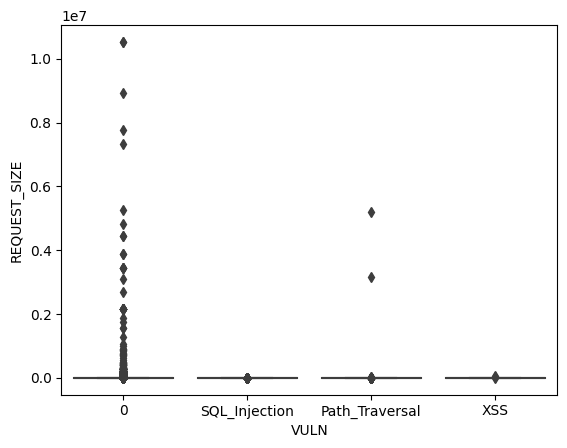

In [87]:
sns.boxplot(data=df, x='VULN', y='REQUEST_SIZE')

<AxesSubplot:xlabel='VULN', ylabel='RESPONSE_CODE'>

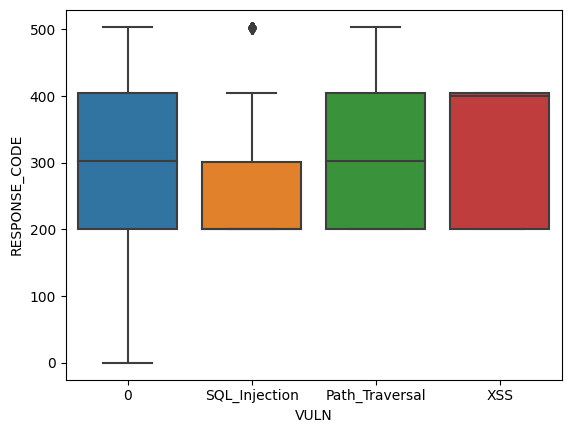

In [88]:
sns.boxplot(data=df, x='VULN', y='RESPONSE_CODE')

# Подход bag of words (с TF-IDF)

Задача похожа на задачу текстовой классификации. В качестве текстов - поле "MATCHED_VARIABLE_VALUE". Явного разделения на слова нет, поэтому будут использованы n-граммы.

## Подготовка данных

Разделение выборки на тренировочную и тестовую в пропорциях, соответствующих распределению классов. И выделение полной выборки для кластеризации

In [89]:
x_train, x_test, y_train, y_test = train_test_split(df.MATCHED_VARIABLE_VALUE, df.VULN_BIN, test_size=0.2, random_state=0, stratify=df.VULN_BIN)
x_all = df.MATCHED_VARIABLE_VALUE
y_all = df.VULN_BIN

Создание векторизатора (2- и 3-граммы)

In [90]:
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )

Расчёт частот встречаемости слов

In [91]:
x_all_counts = count_vect.fit_transform(x_all)

Для преобразования частот встречаемости n-грамм в каждом запросе в TF-IDF нужно знать частоты для всей выборки. Обучим преобразователь TF-IDF

In [92]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_all_counts)

Преобразуем исследуемые частоты появления слов в TF-IDF

In [93]:
x_all_tfidf = tfidf_transformer.transform(x_all_counts)

In [94]:
x_all_tfidf.shape

(57662, 500)

Аналогичную работу проведём для тренировочной выборки, чтобы в будущем обучить классификатор. Для тестовой сымитируем ситуацию, в которой векторизатор не видел новые (тестовые) n-граммы

In [95]:
%%time
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )
count_vect = count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_train_counts)
x_train_tfidf = tfidf_transformer.transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

Wall time: 20 s


## Понижение размерности

Попробуем уменьшить размерность полученного вектора, чтобы визуально оценить разделимость данных

PCA из sklearn не умеет работать с разреженными данными. Поэтому для него разожмём в массивы. Понизим размерность пространства признаков до трёхмерного

In [96]:
embedder_model = PCA(3)
x_pca = embedder_model.fit_transform(x_all_tfidf.toarray())

Нарисуем на картинке

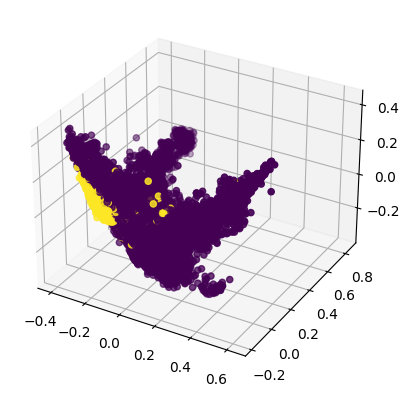

In [97]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=y_all)
plt.show()

И то же самое для отдельных выделенных классов

In [98]:
df.VULN.unique()

array([0, 'SQL_Injection', 'Path_Traversal', 'XSS'], dtype=object)

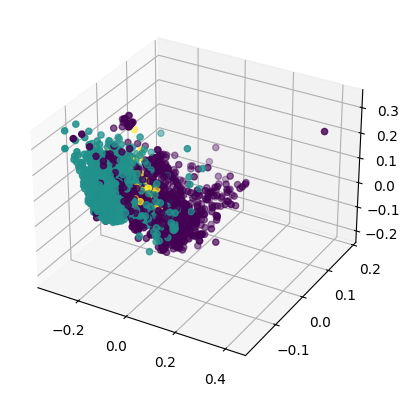

In [99]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=df.VULN.map({'SQL_Injection': 1, 'Path_Traversal': 2, 'XSS': 3}))
plt.show()

Попробуем то же самое в 2D

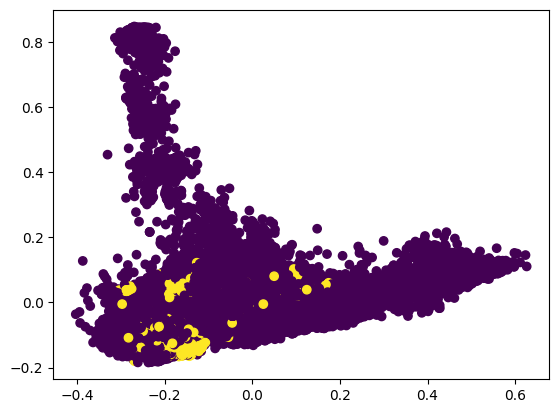

In [100]:
embedder_model = PCA(2)
x_pca = embedder_model.fit_transform(x_all_tfidf.toarray())
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_all)

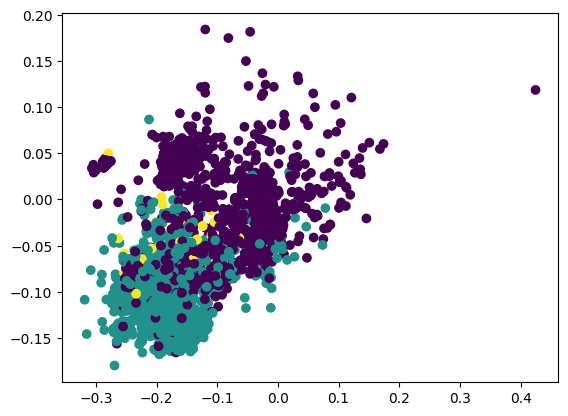

In [101]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=df.VULN.map({'SQL_Injection': 1, 'Path_Traversal': 2, 'XSS': 3}))

Видно, что, хотя часть данных и перемешана, всё равно классы визуально (после уменьшения размерности) разделяются.

## Кластеризация и доразметка

Попробуем кластеризовать имеющиеся данные, чтобы поискать, возможно, дополнительную разметку. Учитывая, что разметили не всю выборку - возможно, получится добавиь к выделенным атакам другие, которые будут замечены при попадании в такой кластер, где уже много атак.

### KMeans

In [102]:
%%time
kmeans = KMeans(
        n_clusters=10,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_all_tfidf)

Wall time: 955 ms


Посмотрим, какая часть элементов в каждом кластере относится к вредоносной

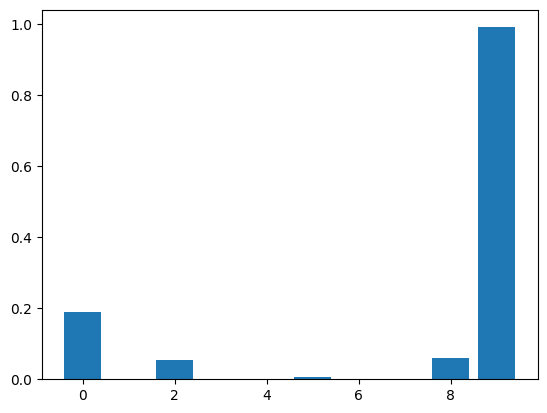

Количество элементов в каждом кластере: [ 2790  1998 10637  1464  4676 18190  1428  1039 14685   755]


In [103]:
df['CLUSTER_NUM'] = kmeans.labels_

df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Попробуем увеличить количство кластеров. Тут воспользовался подсказкой - оттуда взял предположение про 50 (хотя понятно, что это зависит от признаков)

In [104]:
kmeans = KMeans(
        n_clusters=50,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_all_tfidf)

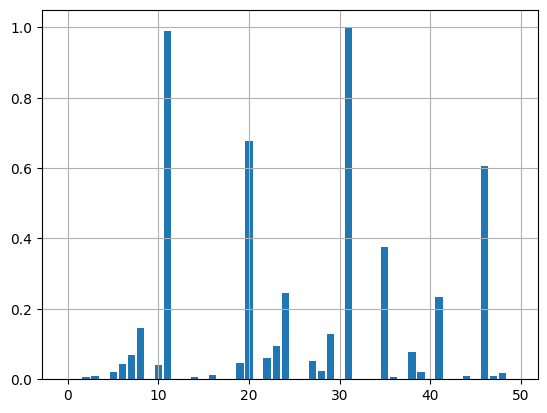

In [105]:
df['CLUSTER_NUM'] = kmeans.labels_
df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.grid()
plt.show()

Посмотрим, какие запросы попали в группу №11 (в которой почти 100% - запросы, размеченные как опасные)

In [106]:
df[df.CLUSTER_NUM == 11].VULN.value_counts()

Path_Traversal    706
SQL_Injection      37
0                   8
Name: VULN, dtype: int64

Видно, что это атаки PathTraversal, только на Windows - используется слэш, характерный для этой ОС (в кодировке - это %5C)

In [107]:
df[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
2069,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,737,200,REQUEST_ARGS,data_0,"{\""open\""\"":\""\""..\\/..\\/..\\/..\\/..\\/..\\/...",lO1kA2QBjksgoq1ekWS1,0,0,11
2895,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,557,400,REQUEST_URI,default_variable_name,/rich/..%5c..%5c..%5c..%5c..%5c..%5c..%5c..%5c...,w_CNA2QBjksgoq1ezR2k,0,0,11
14320,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,581,400,REQUEST_URI,default_variable_name,/zkau/web/56847ef8/zul/images/..%5c..%5c..%5c....,E--FA2QBjksgoq1eZ3aw,0,0,11
29411,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,313,302,REQUEST_HEADERS,Connection,..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C....,98K1_mMBjksgoq1eMWru,0,0,11
37075,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,580,400,REQUEST_URI,default_variable_name,/zkau/web/_zv2015121516/..%5c..%5c..%5c..%5c.....,oe-IA2QBjksgoq1es7x7,0,0,11
37293,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,318,302,REQUEST_HEADERS,Connection,..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C....,W8PA_mMBjksgoq1e4E59,0,0,11
39730,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,586,400,REQUEST_URI,default_variable_name,/zkau/web/174065ac/zul/images/..%5c..%5c..%5c....,BPGiA2QBjksgoq1eKk3K,0,0,11
51285,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,560,400,REQUEST_URI,default_variable_name,/js/..%5c..%5c..%5c..%5c..%5c..%5c..%5c..%5cwi...,je-EA2QBjksgoq1e8Wye,0,0,11


Доразметим все эти запросы как вредоносные:

In [108]:
df.loc[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0), 'VULN'] = 'Path_Traversal'
df.loc[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

Кроме доразметки, получили немного оптимизма - похоже, наши признаки хоть что-то полезное выделяют

Аналогично посмотрим на кластер №20

In [109]:
df[df.CLUSTER_NUM == 20].VULN.value_counts()

Path_Traversal    141
0                  68
SQL_Injection       2
Name: VULN, dtype: int64

В глаза бросается только /etc/passwd. Обращение к этому файлу - не норма для обычного запроса.

In [110]:
df[(df.CLUSTER_NUM == 20) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
565,31.13.20.30,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,823,200,REQUEST_URI,default_variable_name,/etc/pic3518s.jpg,AVdXdiPxq1Ppo9zFzv4k,0,0,20
1316,54.36.150.23,Mozilla/5.0 (compatible; AhrefsBot/5.2; +http:...,235,302,REQUEST_PATH,REQUEST_PATH,/search/public/ru/DOWNLOAD_IMAGE49/{{_cabinetL...,TU5HG2QB5cBXmMW1PPXp,0,0,20
5229,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,755,301,REQUEST_GET_ARGS,REQUEST_GET_ARGS.query,query;cat /etc/passwd;,DLMREmQBoRd31uenAIdZ,0,0,20
5945,178.217.110.17,Mozilla/5.0 (X11; CrOS x86_64 8530.81.0) Apple...,880,200,REQUEST_URI,default_variable_name,/etc/pic3382s.jpg,AVdmuf3Lq1Ppo9zF8Pqf,0,0,20
6717,68.180.228.240,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,195,200,REQUEST_URI,default_variable_name,/etc/pic140b.jpg,AVdbFFa9q1Ppo9zF1xyQ,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...
57239,185.19.21.252,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,759,200,REQUEST_URI,default_variable_name,/etc/pic3593s.jpg,AVdYKaAzq1Ppo9zF0OOU,0,0,20
57430,213.87.149.62,Mozilla/5.0 (iPhone; CPU iPhone OS 6_1_2 like ...,906,200,REQUEST_URI,default_variable_name,/etc/pic390s.jpg,AVdYac3Pq1Ppo9zF0X-C,0,0,20
57508,5.143.231.38,Mozilla/5.0 (compatible; SputnikBot/2.3; +http...,646,200,REQUEST_PATH,REQUEST_PATH,/sitemap/public/ru/med/{{_cabinetLink}}/access...,0Z1qImQB5cBXmMW1qR0T,0,0,20
57627,213.87.146.135,Mozilla/5.0 (Linux; Android 6.0.1; SGP621 Buil...,805,200,REQUEST_URI,default_variable_name,/etc/pic446s.jpg,AVdWiJy0q1Ppo9zFzAdF,0,0,20


Доразметим данные - пусть все неразмеченные обращения к /etc/passwd будут опасными. Хотя их и оказалось не так много.

In [111]:
df[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
1479,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,646,404,REQUEST_URI,default_variable_name,/css/%c0%ae%c0%ae/%c0%ae%c0%ae/%c0%ae%c0%ae/%c...,Z-50A2QBjksgoq1eTFPh,0,0,6
5229,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,755,301,REQUEST_GET_ARGS,REQUEST_GET_ARGS.query,query;cat /etc/passwd;,DLMREmQBoRd31uenAIdZ,0,0,20
14856,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,805,404,REQUEST_URI,default_variable_name,/css/%c0%ae%c0%ae%c1%9c%c0%ae%c0%ae%c1%9c%c0%a...,jO1vA2QBjksgoq1eJ_HM,0,0,6
23162,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,660,404,REQUEST_URI,default_variable_name,/zkau/web/174065ac/%c0%ae%c0%ae/%c0%ae%c0%ae/%...,Uu-KA2QBjksgoq1epOhY,0,0,6
23699,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,223,404,REQUEST_ARGS,amp;nn,`/etc/passwd`,voJ02mMBS0qQ_9B6hjdL,0,0,20


In [112]:
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0), 'VULN'] = 'Path_Traversal'
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

Заодно посмотрим ещё и обращения к скриптам.

In [113]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')].MATCHED_VARIABLE_VALUE

2472     /bin/HS55i56jGB3bSAIi.sh
2491     /bin/PvO3tauSA9PatKGv.sh
15138    /bin/ljDFqjM47K1qCR0j.sh
23278    /bin/u79k8ojFq5C7GDX5.sh
24264    /bin/4K09ib44JPGAG33d.sh
43819    /bin/210Fs65Pto8KA7h0.sh
55736    /bin/oHVb35ul8gh9iGvG.sh
55923    /bin/iguS3G0of2hM7x4V.sh
Name: MATCHED_VARIABLE_VALUE, dtype: object

Тоже доразметим их как вредоносные

In [114]:
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')) & (df.VULN_BIN == 0), 'VULN'] = 'Remote_Code_Execution'
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

Можно было бы ещё посмотреть данные. Но для ускорения попробуем ещё DBSCAN и далее перейдём к созданию самой предсказывающей модели.

### DBSCAN

In [115]:
%%time
dbscan = DBSCAN(
        eps=0.8,
        min_samples=5,
        n_jobs=-1
    ).fit(x_all_tfidf)

Wall time: 1min 50s


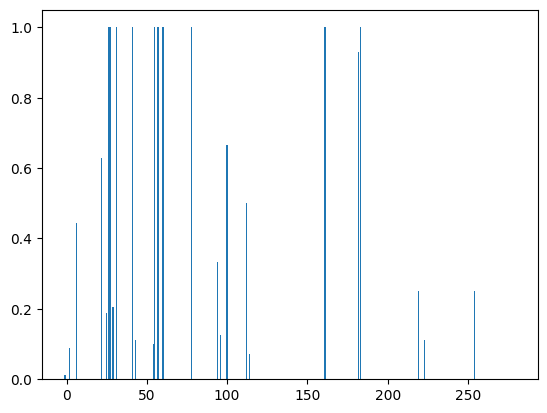

Количество элементов в каждом кластере: [    1  1575  1041   430  1215  2556 12075    58   194   909  1487   751
   104   632 10009   764  1270   166   189   539   211   739  3480   525
   106   385   582   740   281  1023   471   125  1033   288  1208   384
  1959   298   399   502  1390   754  1151   361   897   276   387  1326
    57   359]


In [116]:
df['CLUSTER_NUM'] = dbscan.labels_

df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Посмотрим, какая часть кластеров содержит только (или почти только) безопасные запросы, какая - смешанные, и какая - опасные.

Видно, что запросы разделяются. Есть ещё несколько кластеров, в которых данные смешались, и для улучшения качества модели можно было бы их доразметить.

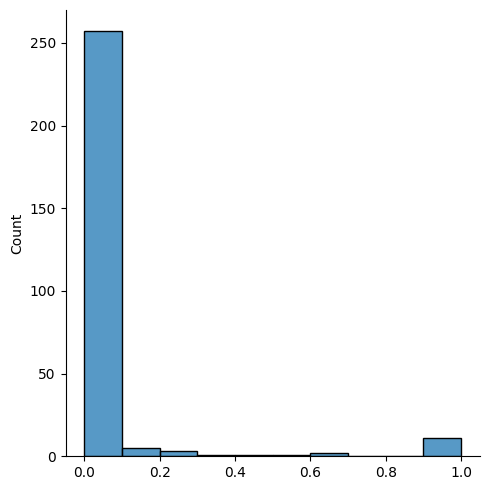

In [117]:
sns.displot(part_vuln_in_group, bins = 10)

## Классификация

Какая-то разметка уже подготовлена, теперь можно попробовать собрать модель. Для начала используем самый простой вариант - без дополнительных признаков только по тем TF-IDF, которые нагенерированы выше.

В качестве метрики будем смотреть на recall, чтобы пропустить минимум "опасных" запросов (минимизировать ложноотрицательные предсказания)

### Наивный байесовский классификатор

Начнём с наивного байесовского классификатора - он оценивает влияние каждого признака в отдельности в предположении, что признаки не зависят друг от друга

In [118]:
%%time
clf = MultinomialNB().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10954
           1       0.74      0.63      0.68       579

    accuracy                           0.97     11533
   macro avg       0.86      0.81      0.83     11533
weighted avg       0.97      0.97      0.97     11533

Wall time: 44 ms


In [119]:
%%time
clf = ComplementNB().fit(x_train_tfidf.toarray(), y_train)
y_pred = clf.predict(x_test_tfidf.toarray())
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10954
           1       0.31      0.90      0.46       579

    accuracy                           0.89     11533
   macro avg       0.65      0.90      0.70     11533
weighted avg       0.96      0.89      0.92     11533

Wall time: 185 ms


### К-ближайших соседей

In [120]:
%%time
model = KNeighborsClassifier(n_neighbors=5).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf.toarray())
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10954
           1       0.31      0.90      0.46       579

    accuracy                           0.89     11533
   macro avg       0.65      0.90      0.70     11533
weighted avg       0.96      0.89      0.92     11533

Wall time: 87.1 ms


### SVM

Разделяющие плоскости в n-мерном пространстве

In [121]:
%%time
clf = SVC().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10954
           1       0.99      0.90      0.94       579

    accuracy                           0.99     11533
   macro avg       0.99      0.95      0.97     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 1min 8s


### Деревья

Набор условий, создаваемый по максимальной информативности

In [122]:
%%time
clf = DecisionTreeClassifier().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10954
           1       0.94      0.96      0.95       579

    accuracy                           0.99     11533
   macro avg       0.97      0.98      0.97     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 4.79 s


### Случайный лес

Набор деревьев, исследующих разные наборы признаков

In [123]:
%%time
clf = RandomForestClassifier(max_depth=50, n_jobs=-1, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10954
           1       0.99      0.91      0.95       579

    accuracy                           1.00     11533
   macro avg       0.99      0.96      0.97     11533
weighted avg       1.00      1.00      1.00     11533

Wall time: 5.18 s


### AdaBoost

Бустинг (поправка на неправильно классифицированных запросах)

In [124]:
%%time
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10954
           1       0.95      0.90      0.92       579

    accuracy                           0.99     11533
   macro avg       0.97      0.95      0.96     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 15.7 s


## Выбранная модель

В качестве итоговой модели будет использован наивный байесовский классификатор - он показал достаточно хороший результат, должен быть стабилен (результат оценивается независимо по всем признакам), быстро работает.

In [125]:
%%time
clf = ComplementNB().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10954
           1       0.31      0.90      0.46       579

    accuracy                           0.89     11533
   macro avg       0.65      0.90      0.70     11533
weighted avg       0.96      0.89      0.92     11533

Wall time: 28 ms


Для использования в сервисе обучим модель на всём наборе данных:

In [126]:
%%time
clf = ComplementNB().fit(x_all_tfidf, y_all)

Wall time: 14 ms


Повторим предсказания для обучающих данных (посмотрим, как модель их зампомнила)

In [127]:
%%time
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     10954
           1       0.31      0.86      0.45       579

    accuracy                           0.89     11533
   macro avg       0.65      0.88      0.70     11533
weighted avg       0.96      0.89      0.92     11533

Wall time: 14 ms


In [128]:
joblib.dump(clf, 'data/requests_model.pkl')

['requests_model.pkl']

Для дальнейшего использования загружать так:

In [129]:
model_prod = joblib.load('data/requests_model.pkl')

Ещё для использования модели нужно уметь превращать текст в вектора. Чтобы не считать частоты каждый раз при запуске приложения, сохраним данные:

In [131]:
%%time
count_vect = CountVectorizer(lowercase=False, max_features=500,
                             ngram_range=(2,3), analyzer='char')
count_vect = count_vect.fit(x_all)
x_all_counts = count_vect.transform(x_all)

tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_all_counts)

Wall time: 13.3 s


In [132]:
joblib.dump(count_vect, 'data/requests_count_vect.pkl')

['requests_count_vect.pkl']

In [133]:
joblib.dump(tfidf_transformer, 'data/requests_tfidf_transformer.pkl')

['requests_tfidf_transformer.pkl']

В разделе "Future work" указал бы, что можно было бы попробовать использовать другие признаки (сейчас используется только одна колонка) ещё поулучшать модель (как минимум, поэкспериментировать с гиперпараметрами). Можно было бы использовать другие подходы к векторизации текста, другие бустинги, нейросетевой подход.

Если получится - разгадать загадку странных символов, ломающих разметку в CSV, но обнаруживающихся в строках со многообещающими вхождениями "SQL Injection" и подобными. Посмотреть на EVENT_ID - глазами в нём прослеживается некий шаблон, состоящий из двух частей. Возможно, от этого поля что-то зависит.